In [207]:
# import numerical functions, plotting functions and statistical functions
import numpy as np
# !pip install pip
# !pip install --upgrade pip
# !pip install scipy
import scipy as sp
import scipy.stats
import pandas as pd
import json
from sklearn.preprocessing import RobustScaler

# !pip install pystan
import stan
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# !pip install arviz
import arviz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [208]:
# !pip uninstall numba
# !pip install --upgrade numba

In [209]:
def diagnose(name):
    if 'disease' in name:
        return 1
    else:
        return 0

def region_id(segment_region):
    if "glomerulus" in segment_region:
        return 1
    elif "tubule" in segment_region:
        return 2
    else:
        return -1
    # elif segment_region == "neg tubule":
    #     return 3
    # else:
    #     return -1

In [210]:
raw_df = pd.read_csv('./data/kidney_countdata.txt', sep='\t', quotechar='"')
raw_df.rename(columns={'Unnamed: 0': 'gene'}, inplace=True)

meta_df = pd.read_csv('./data/kidney_metadata.txt', sep='\t', quotechar='"')
meta_df.rename(columns={'Unnamed: 0': 'ROI'}, inplace=True)
meta_df['diagnosis'] = meta_df['slide name'].map(diagnose)
meta_df['segment_region'] = meta_df['segment'] + ' ' + meta_df['region']
meta_df['region_id'] = meta_df['segment_region'].map(region_id)
print(meta_df.groupby(['region_id', 'diagnosis']).count())


                     ROI  construct  read_pattern  expected_neg  slide name  \
region_id diagnosis                                                           
1         0           81         81            81            81          81   
          1          109        109           109           109         109   
2         0           36         36            36            36          36   
          1           50         50            50            50          50   

                     class  segment  area  region  pathology  nuclei  \
region_id diagnosis                                                    
1         0             81       81    81      81         68      81   
          1            109      109   109     109         83     109   
2         0             36       36    36      36          0      36   
          1             50       50    50      50          0      50   

                     segment_region  
region_id diagnosis                  
1         0     

### Data Summary


In [211]:
print(f"Number of genes: {raw_df.shape[0]}")
print(f"Number of ROIs: {len(meta_df['ROI'].unique())}")
print("Diagnosis counts:")
print(meta_df['diagnosis'].value_counts())
print(f"ROIs per individual")
print(meta_df['slide name'].value_counts())

Number of genes: 18642
Number of ROIs: 276
Diagnosis counts:
1    159
0    117
Name: diagnosis, dtype: int64
ROIs per individual
disease3     59
normal3      59
disease1B    39
disease2B    37
normal2B     35
disease4     24
normal4      23
Name: slide name, dtype: int64


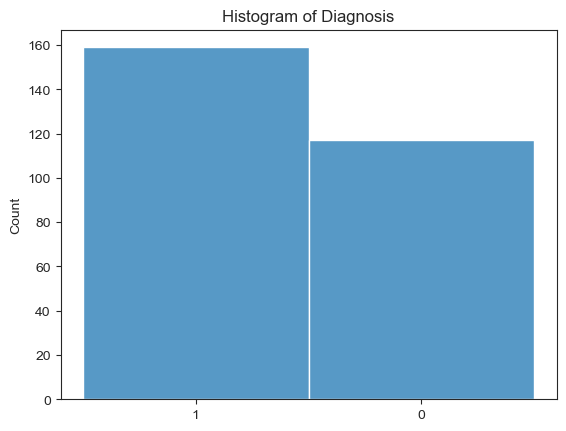

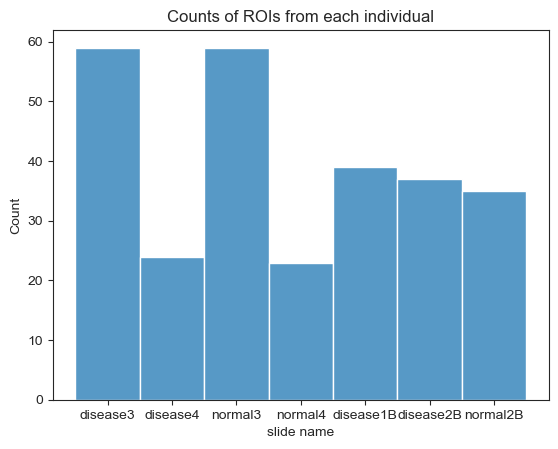

In [212]:

sns.histplot([str(x) for x in meta_df['diagnosis'].values])
plt.title('Histogram of Diagnosis')
plt.show()

sns.histplot(meta_df['slide name'])
plt.title('Counts of ROIs from each individual')
plt.show()

/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3247660967.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = raw_df.mean(axis=0)


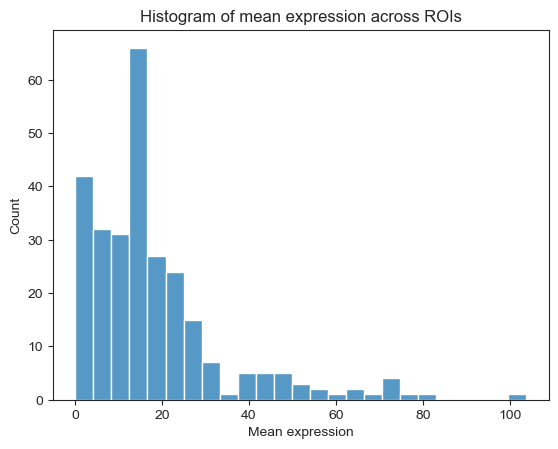

/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3247660967.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stds = raw_df.std(axis=0)


KeyboardInterrupt: 

In [213]:
means = raw_df.mean(axis=0)
sns.histplot(means)
plt.title('Histogram of mean expression across ROIs')
plt.xlabel('Mean expression')
plt.show()

stds = raw_df.std(axis=0)
sns.histplot(stds)
plt.title('Histogram of standard deviation of expression across ROIs')
plt.xlabel('Standard deviation of expression')
plt.show()

In [ ]:
def prepare_and_save_data(test_individuals=['disease2B', 'normal4'], normalization='z-score', region=False, n_genes=-1):
    # Option 0: Remove test subjects from the data
    if len(test_individuals) > 0:
        test_ROIs = meta_df[meta_df['slide name'].isin(test_individuals)]['ROI'].values
        suffix = '_indv'
    # Option 2: randomly sample 20 ROIs from each class to be the test set
    else:
        d_vals = meta_df[meta_df['diagnosis'] == 1]['ROI'].values
        d_vals = np.random.permutation(d_vals)
        d_vals = d_vals[:20]
        n_vals = meta_df[meta_df['diagnosis'] == 0]['ROI'].values
        n_vals = np.random.permutation(n_vals)
        n_vals = n_vals[:20]
        test_ROIs = np.concatenate((d_vals, n_vals))
        suffix = '_random_20'
    
    if n_genes > 0:
        df = raw_df.sample(n_genes, axis=0)
    else:
        df = raw_df
    column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) > 0 and col not in test_ROIs]
    test_column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) > 0 and col in test_ROIs]

    # # Option 1: normalize by sum of all counts for an ROI, multiplied by 1,000 to prevent underflow
    if normalization == 'sum':
        X = [(df[col]*1000/sum(df[col])).tolist() for col in column_list]
        test_X = [(df[col]*1000/sum(df[col])).tolist() for col in test_column_list]
    # Option 2: normalize using z-score method:
    elif normalization == 'z-score':
        X = [sp.stats.zscore(df[col]).tolist() for col in column_list]
        test_X = [sp.stats.zscore(df[col]).tolist() for col in test_column_list]
    # # Option 3: normalize using min-max method:
    elif normalization == 'min-max':
        X = [((df[col]-min(df[col]))/(max(df[col])-min(df[col]))).tolist() for col in column_list]
        test_X = [((df[col]-min(df[col]))/(max(df[col])-min(df[col]))).tolist() for col in test_column_list]
    # # Option 4: normalize using quantile method:
    elif normalization == 'quantile':
        X = []
        test_X = []
        for col in column_list:
            rs = RobustScaler()
            scaled = rs.fit_transform(df[col].values.reshape(-1, 1))
            X.append(scaled.tolist())

        for col in test_column_list:
            rs = RobustScaler()
            scaled = rs.fit_transform(df[col].values.reshape(-1, 1))
            test_X.append(scaled.tolist())
    else:
        raise ValueError('Invalid normalization method')

    Y = []
    for col in column_list:
        Y.append(int(meta_df[meta_df['ROI']==col]['diagnosis'].values[0]))

    test_Y = []
    for col in test_column_list:
        test_Y.append(int(meta_df[meta_df['ROI']==col]['diagnosis'].values[0]))


    ROI_df = pd.DataFrame(column_list, columns=['ROI'])
    joined = ROI_df.merge(meta_df, on='ROI', how='left')
    p = len(joined['region_id'].unique())

    test_ROI_df = pd.DataFrame(test_column_list, columns=['ROI'])
    test_regions= test_ROI_df.merge(meta_df, on='ROI', how='left')['region_id'].values.tolist()

    if region:
        reg_suffix = '_reg'
        data = {'N': len(X), 'q': len(df), 'p': p, 'X': X, 'Y': Y, 'region': joined['region_id'].values.tolist()}
    else:
        reg_suffix = ''
        data = {'N': len(X), 'q': len(df), 'X': X, 'Y': Y}

    with open(f"/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/genes/model_norm/model{reg_suffix}{suffix}.data.json", "w") as f:
        json.dump(data, f)
    
    return data, test_X, test_Y, test_regions


In [ ]:
region_setting = True
data_indv, test_X_indv, test_Y_indv, test_region_indv = prepare_and_save_data(test_individuals=['disease2B', 'normal2B'], normalization='z-score', region=region_setting)
data_rand, test_X_rand, test_Y_rand, test_region_rand = prepare_and_save_data(test_individuals=[], normalization='z-score', region=region_setting)

In [ ]:
print(min(data_indv['region']))

1


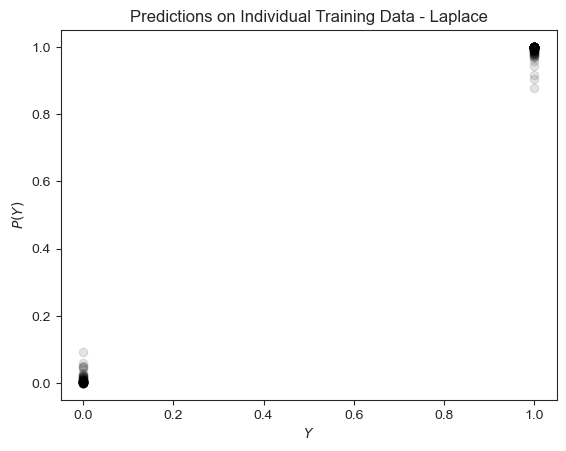

Training accuracy - Laplace:
\begin{tabular}{llrrrrr}
\toprule
  model &   sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Laplace & Individual &  0 &   0.009850 &   0.015322 &        82 &       82 \\
Laplace & Individual &  1 &   0.991848 &   0.017674 &       122 &      122 \\
\bottomrule
\end{tabular}



/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))


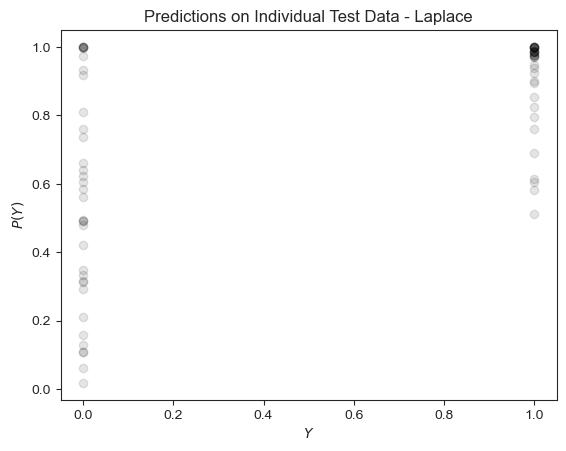

Testing accuracy - Laplace:
\begin{tabular}{llrrrrr}
\toprule
  model &   sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Laplace & Individual &  0 &   0.559158 &   0.320712 &        17 &       35 \\
Laplace & Individual &  1 &   0.907324 &   0.138389 &        37 &       37 \\
\bottomrule
\end{tabular}



/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:77: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))


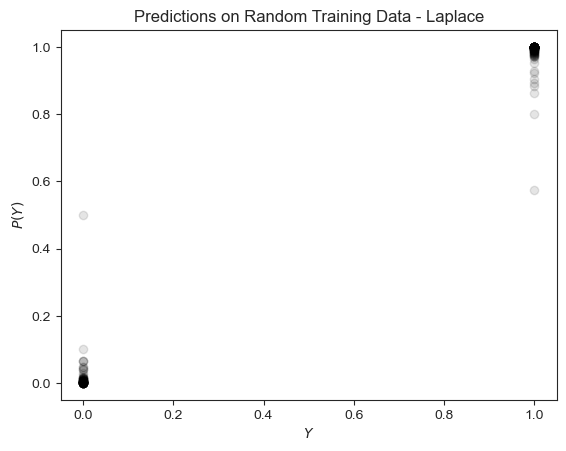

Training accuracy - Laplace:
\begin{tabular}{llrrrrr}
\toprule
  model & sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Laplace &   Random &  0 &   0.014786 &   0.052556 &        97 &       97 \\
Laplace &   Random &  1 &   0.986065 &   0.044255 &       139 &      139 \\
\bottomrule
\end{tabular}



/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))


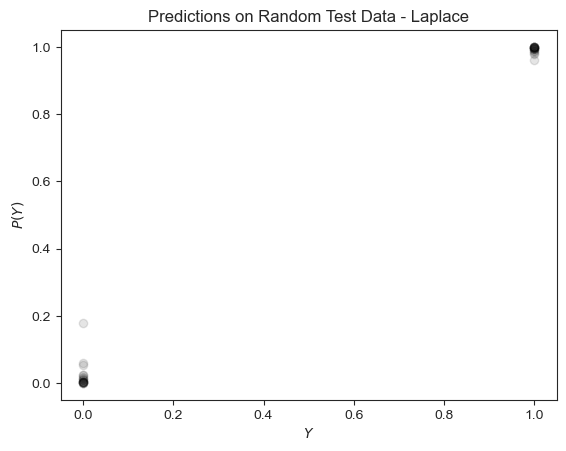

Testing accuracy - Laplace:
\begin{tabular}{llrrrrr}
\toprule
  model & sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Laplace &   Random &  0 &   0.021049 &   0.040393 &        20 &       20 \\
Laplace &   Random &  1 &   0.993088 &   0.009517 &        20 &       20 \\
\bottomrule
\end{tabular}



/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:77: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:22: RuntimeWarning: overflow encountered in exp
  Y_tilde = np.exp(z) / (1 + np.exp(z))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:22: RuntimeWarning: invalid value encountered in divide
  Y_tilde = np.exp(z) / (1 + np.exp(z))


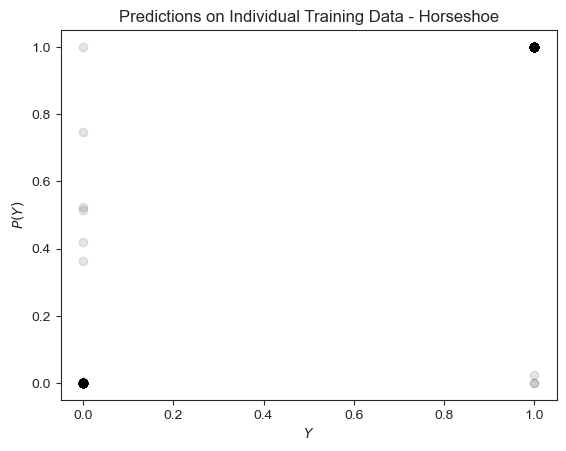

/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))


Training accuracy - Horseshoe:
\begin{tabular}{llrrrrr}
\toprule
    model &   sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Horseshoe & Individual &  0 &   0.043609 &   0.166630 &        78 &       82 \\
Horseshoe & Individual &  1 &   0.973904 &   0.159438 &       111 &      122 \\
\bottomrule
\end{tabular}



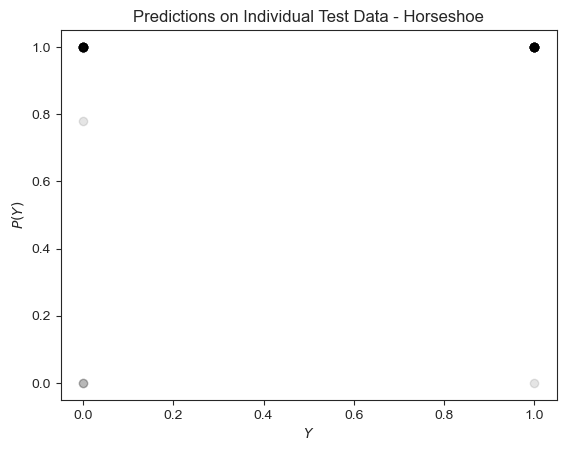

Testing accuracy - Horseshoe:
\begin{tabular}{llrrrrr}
\toprule
    model &   sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Horseshoe & Individual &  0 &   0.907822 &   0.284465 &         3 &       35 \\
Horseshoe & Individual &  1 &   0.972973 &   0.164399 &        36 &       37 \\
\bottomrule
\end{tabular}



/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:77: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:22: RuntimeWarning: overflow encountered in exp
  Y_tilde = np.exp(z) / (1 + np.exp(z))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:22: RuntimeWarning: invalid value encountered in divide
  Y_tilde = np.exp(z) / (1 + np.exp(z))


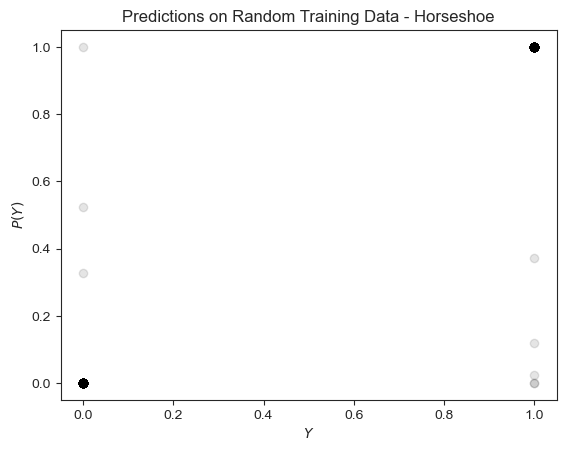

/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))


Training accuracy - Horseshoe:
\begin{tabular}{llrrrrr}
\toprule
    model & sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Horseshoe &   Random &  0 &   0.019084 &   0.118397 &        95 &       97 \\
Horseshoe &   Random &  1 &   0.951748 &   0.206183 &        88 &      139 \\
\bottomrule
\end{tabular}



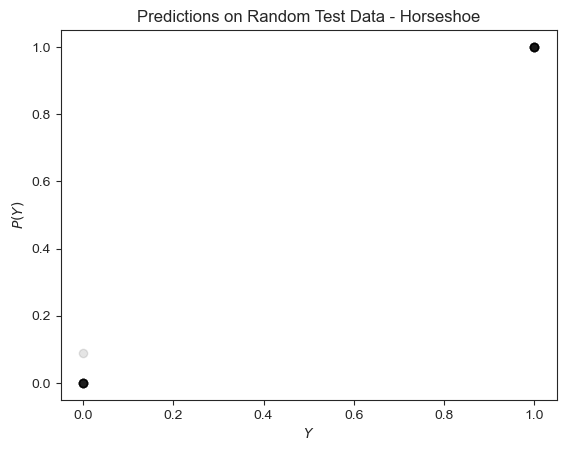

Testing accuracy - Horseshoe:
\begin{tabular}{llrrrrr}
\toprule
    model & sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Horseshoe &   Random &  0 &   0.004473 &   0.020003 &        20 &       20 \\
Horseshoe &   Random &  1 &   1.000000 &   0.000000 &        20 &       20 \\
\bottomrule
\end{tabular}



/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:77: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))


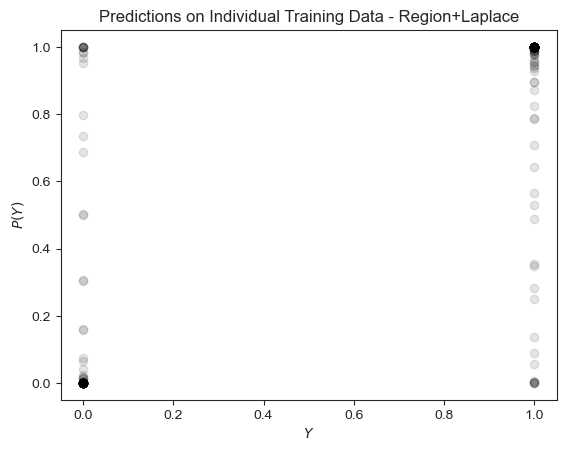

Training accuracy - Region+Laplace:
\begin{tabular}{llrrrrr}
\toprule
         model &   sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Region+Laplace & Individual &  0 &   0.186707 &   0.356864 &        66 &       82 \\
Region+Laplace & Individual &  1 &   0.877049 &   0.281441 &       108 &      122 \\
\bottomrule
\end{tabular}



/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))


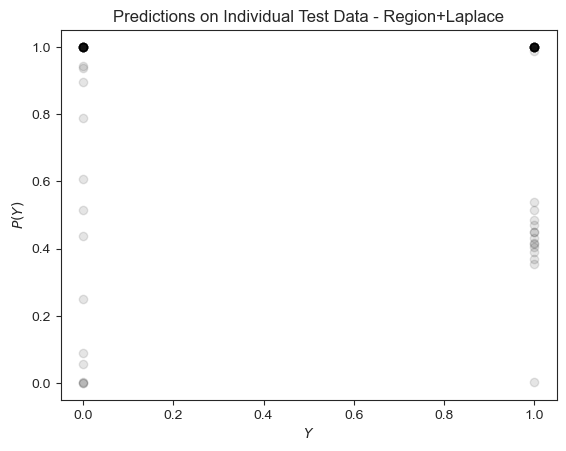

Testing accuracy - Region+Laplace:
\begin{tabular}{llrrrrr}
\toprule
         model &   sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Region+Laplace & Individual &  0 &   0.786355 &   0.361693 &         7 &       35 \\
Region+Laplace & Individual &  1 &   0.774977 &   0.301479 &        25 &       37 \\
\bottomrule
\end{tabular}



/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:77: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))


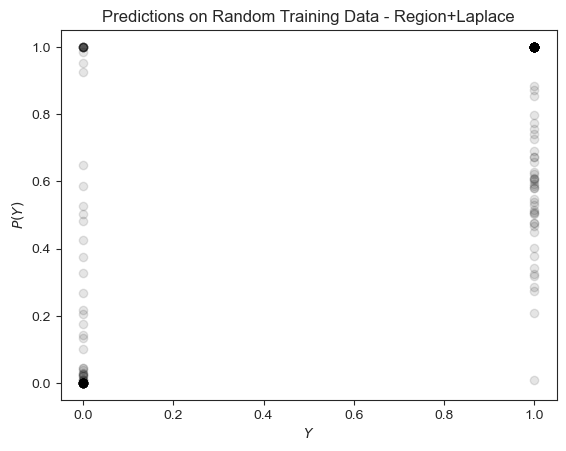

Training accuracy - Region+Laplace:
\begin{tabular}{llrrrrr}
\toprule
         model & sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Region+Laplace &   Random &  0 &   0.223254 &   0.366005 &        65 &       82 \\
Region+Laplace &   Random &  1 &   0.845624 &   0.239587 &       109 &      122 \\
\bottomrule
\end{tabular}



/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))


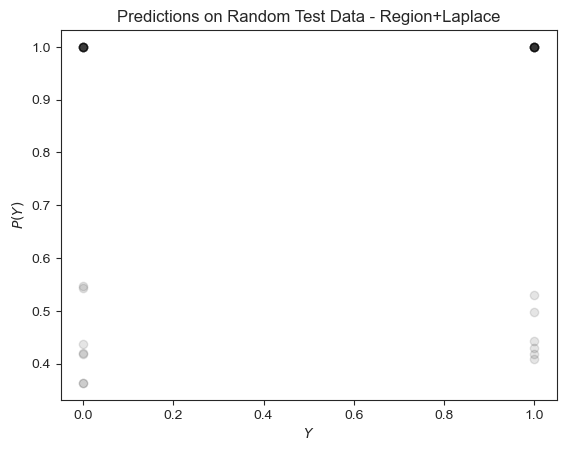

Testing accuracy - Region+Laplace:
\begin{tabular}{llrrrrr}
\toprule
         model & sampling &  Y &  avg. P(Y) &  std. P(Y) &  P(Y)>0.5 &  samples \\
\midrule
Region+Laplace &   Random &  0 &   0.804552 &   0.276583 &         5 &       20 \\
Region+Laplace &   Random &  1 &   0.836358 &   0.257658 &        15 &       20 \\
\bottomrule
\end{tabular}



/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/3562254264.py:77: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(s_g.to_latex(index=False))


In [ ]:
def visualize_results(data, test_X, test_Y, test_regions=[], suffix='_indv', sampling='', model=''):
    plot_suffix = f' - {model}'
    t_out = pd.read_csv(f"/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output{suffix}.csv",
                        comment='#')
    if 'alpha' in t_out.columns:
        if abs(t_out['alpha'][0] > 0.0001):
            print("WARNING: ALPHA SIGNIFICANT")

    if 'Region' in model:
        t_betas = [[t_out[col][0] for col in t_out.columns if 'beta.1' in col],
                   [t_out[col][0] for col in t_out.columns if 'beta.2' in col],
                   [t_out[col][0] for col in t_out.columns if 'beta.3' in col]]
        scaled = []
        for i in range(len(data['X'])):
            scaled.append(np.array(t_betas[data['region'][i]-1]) * data['X'][i][:])
    else:
        t_betas = [t_out[col][0] for col in t_out.columns if 'beta' in col]
        scaled = [np.array(t_betas) * x[:] for x in data['X']]

    # z = [t_out['alpha'][0] + sum(s) for s in scaled]
    z = [sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    plt.scatter(data['Y'], Y_tilde, color='k', alpha=0.1, zorder=-10)
    plt.ylabel(r'$P(Y)$')
    plt.xlabel(r'$Y$')
    plt.title(f"Predictions on {sampling} Training Data{plot_suffix}")
    plt.savefig(f"./plots/train_predictions{suffix}.png")
    plt.show()

    print(f"Training accuracy{plot_suffix}:")
    accuracy = []
    for i in range(len(Y_tilde)):
        if Y_tilde[i] > 0.5:
            accuracy.append(1 if data['Y'][i] == 1 else 0)
        else:
            accuracy.append(1 if data['Y'][i] == 0 else 0)
    summary_table = pd.DataFrame({'Y': data['Y'], 'avg. P(Y)': Y_tilde, 'std. P(Y)': Y_tilde, 'P(Y)>0.5': accuracy, 'samples': 1})
    s_g = summary_table.groupby('Y').agg({'avg. P(Y)': 'mean', 'std. P(Y)': 'std', 'P(Y)>0.5': 'sum', 'samples': 'sum'})
    s_g.reset_index(inplace=True)
    s_g['model'] = model
    s_g['sampling'] = sampling
    s_g = s_g[['model', 'sampling', 'Y', 'avg. P(Y)', 'std. P(Y)', 'P(Y)>0.5', 'samples']]
    print(s_g.to_latex(index=False))

    if 'Region' in model:
        scaled = []
        for i in range(len(test_X)):
            scaled.append(np.array(t_betas[test_regions[i]-1]) * data['X'][i][:])
    else:
        scaled = [np.array(t_betas) * x[:] for x in test_X]

    # z = [t_out['alpha'][0] + sum(s) for s in scaled]
    z = [sum(s) for s in scaled]
    z_capped = [min(100, x) for x in z]
    Y_tilde = np.exp(z_capped) / (1 + np.exp(z_capped))
    plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
    plt.ylabel(r'$P(Y)$')
    plt.xlabel(r'$Y$')
    # plt.yscale('log')
    plt.title(f"Predictions on {sampling} Test Data{plot_suffix}")
    plt.savefig(f"./plots/test_predictions{suffix}.png")
    plt.show()

    accuracy = []
    for i in range(len(Y_tilde)):
        if Y_tilde[i] > 0.5:
            accuracy.append(1 if test_Y[i] == 1 else 0)
        else:
            accuracy.append(1 if test_Y[i] == 0 else 0)
    summary_table = pd.DataFrame({'Y': test_Y, 'avg. P(Y)': Y_tilde, 'std. P(Y)': Y_tilde, 'P(Y)>0.5': accuracy, 'samples': 1})
    s_g = summary_table.groupby('Y').agg({'avg. P(Y)': 'mean', 'std. P(Y)': 'std', 'P(Y)>0.5': 'sum', 'samples': 'sum'})
    s_g.reset_index(inplace=True)
    s_g['model'] = model
    s_g['sampling'] = sampling
    s_g = s_g[['model', 'sampling', 'Y', 'avg. P(Y)', 'std. P(Y)', 'P(Y)>0.5', 'samples']]
    print(f"Testing accuracy{plot_suffix}:")
    print(s_g.to_latex(index=False))

visualize_results(data_indv, test_X_indv, test_Y_indv, [], suffix='_indv', sampling='Individual', model='Laplace')
visualize_results(data_rand, test_X_rand, test_Y_rand, [], suffix='_random_20', sampling='Random', model='Laplace')
visualize_results(data_indv, test_X_indv, test_Y_indv, [], suffix='_indv_horseshoe', sampling='Individual', model='Horseshoe')
visualize_results(data_rand, test_X_rand, test_Y_rand, [], suffix='_rand_horseshoe', sampling='Random', model='Horseshoe')
visualize_results(data_indv, test_X_indv, test_Y_indv, test_region_indv, suffix='_indv_region', sampling='Individual', model='Region+Laplace')
visualize_results(data_indv, test_X_rand, test_Y_rand, test_region_rand, suffix='_rand_region', sampling='Random', model='Region+Laplace')

In [ ]:
print([z for z in range(-700, 700, 100)])
[np.exp(z) / (1 + np.exp(z)) for z in range(-700, 700, 100)]

[-700, -600, -500, -400, -300, -200, -100, 0, 100, 200, 300, 400, 500, 600]


[9.85967654375977e-305,
 2.6503965530043108e-261,
 7.124576406741286e-218,
 1.9151695967140057e-174,
 5.148200222412013e-131,
 1.3838965267367376e-87,
 3.720075976020836e-44,
 0.5,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

      lp__         alpha    beta.1        beta.2        beta.3        beta.4  \
0 -7.00542 -3.572360e-08 -0.024306  1.534780e-11  8.239680e-09 -3.627200e-12   

         beta.5        beta.6        beta.7        beta.8  ...    z.195  \
0 -9.928970e-09 -2.264130e-11 -3.671840e-13 -3.286450e-11  ...  10.9275   

     z.196    z.197    z.198    z.199    z.200    z.201   z.202    z.203  \
0  7.29737  10.0059  5.19541  8.76131  9.23094  4.42867  3.4662  8.77926   

     z.204  
0  8.28779  

[1 rows x 18848 columns]
0.17833


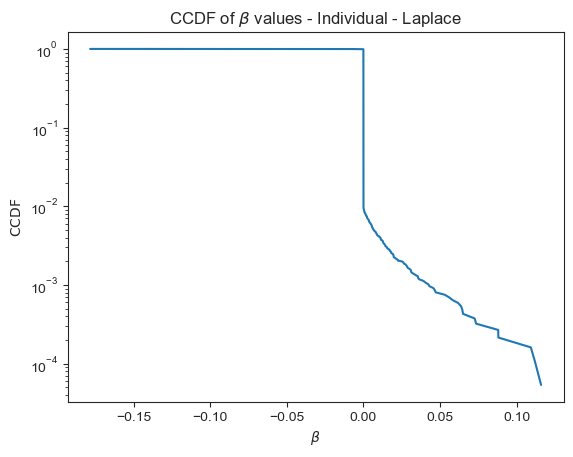

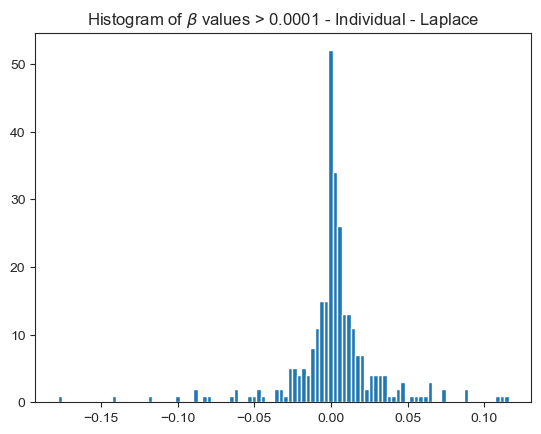

295
      lp__         alpha    beta.1        beta.2        beta.3        beta.4  \
0 -9.09147  3.803000e-12 -0.024968 -1.056300e-12  2.285990e-09 -4.319690e-08   

    beta.5        beta.6        beta.7        beta.8  ...    z.227    z.228  \
0 -0.00975 -8.285020e-12  1.609670e-11 -1.486560e-11  ...  3.87112  4.02831   

     z.229    z.230    z.231    z.232    z.233    z.234    z.235    z.236  
0  8.21623  5.47415  7.87667  7.35965  6.68298  2.26443  10.1749  9.04275  

[1 rows x 18880 columns]
0.279499


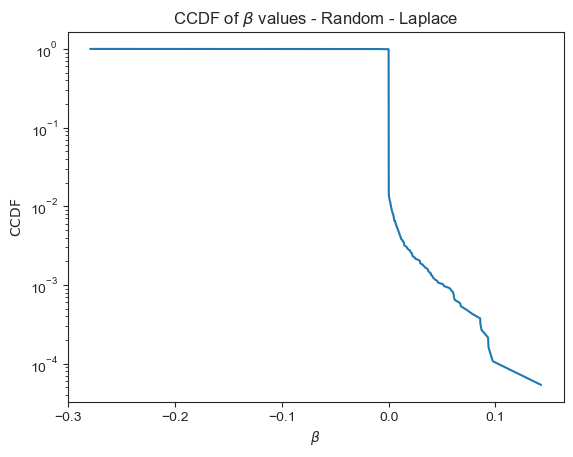

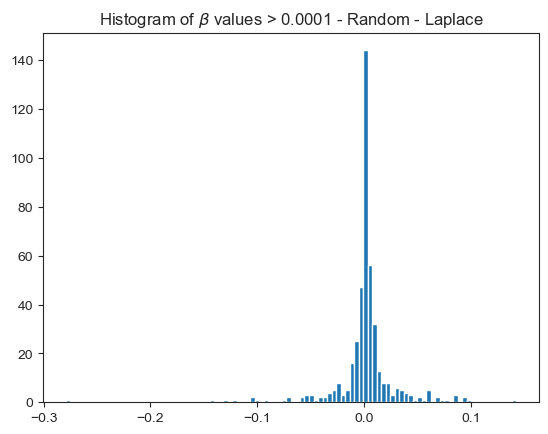

439
     lp__  lambda.1  lambda.2  lambda.3  lambda.4  lambda.5  lambda.6  \
0  175685    56.461   2.09069  0.498516   1.11519   1.78319   0.28401   

   lambda.7  lambda.8  lambda.9  ...    z.227    z.228    z.229    z.230  \
0   0.24932  0.490052  0.631903  ...  483.634  617.626  501.587  396.316   

     z.231    z.232   z.233    z.234    z.235    z.236  
0  502.991  365.319  330.54  260.719  853.718  828.178  

[1 rows x 37522 columns]
29.8818


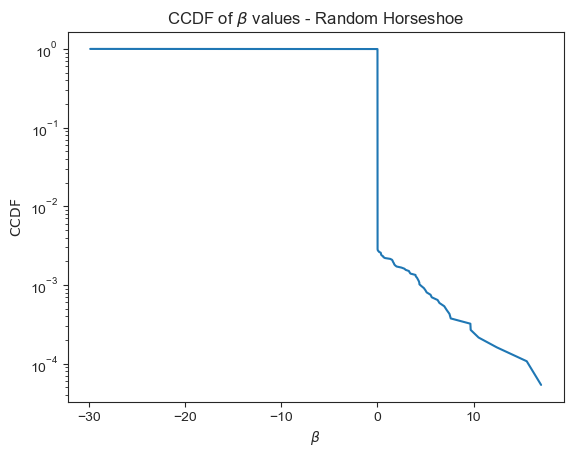

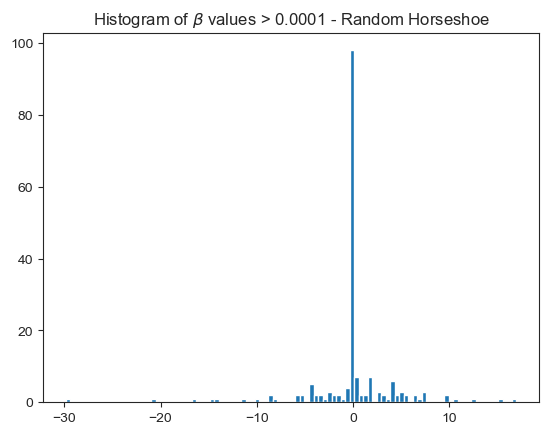

183
     lp__  lambda.1  lambda.2  lambda.3  lambda.4  lambda.5  lambda.6  \
0  178272   49.8811   1.98317   1.19318  0.243118  0.438696   1.26581   

   lambda.7  lambda.8  lambda.9  ...    z.195    z.196    z.197    z.198  \
0   0.34011  0.499379  0.450687  ...  909.244  686.726  729.633  331.075   

     z.199    z.200    z.201    z.202    z.203    z.204  
0  632.535  414.256  392.598  349.705  514.113  576.731  

[1 rows x 37490 columns]
16.842


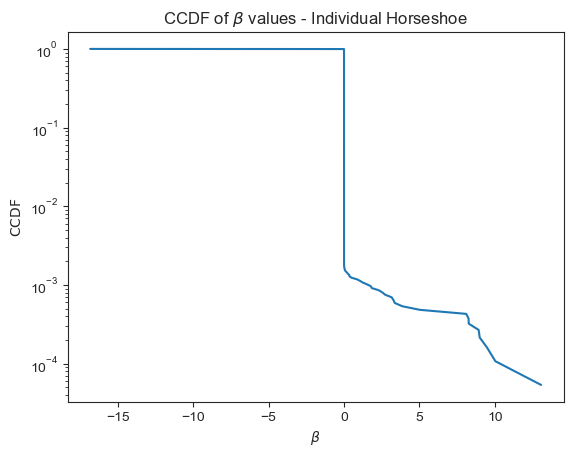

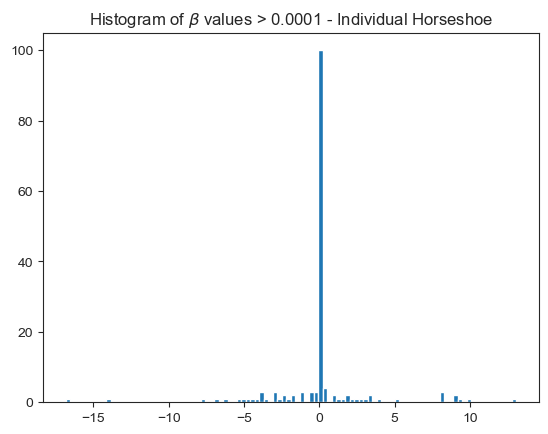

158


In [ ]:
def visualize_betas(suffix='_indv', plot_suffix='', threshold=0.0001):
    t_out = pd.read_csv(f"/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output{suffix}.csv",
                        comment='#')
    print(t_out.head())
    t_betas = [t_out[col][0] for col in t_out.columns if 'beta' in col]
    t_betas.sort()
    ccdf = 1 - np.array(range(len(t_betas))) / len(t_betas)
    print(max(np.abs(t_betas)))
    plt.plot(t_betas, ccdf)
    # plt.xscale('symlog')
    plt.yscale('log')
    beta_str = r'$\beta$'
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\mathrm{CCDF}$')
    plt.title(f"CCDF of {beta_str} values{plot_suffix}")
    plt.show()

    t_betas = [t_out[col][0] for col in t_out.columns if 'beta' in col]
    gene_df = pd.DataFrame({'gene': raw_df['gene'].values, 'beta': t_betas})
    filtered_genes = gene_df[(gene_df['beta'] > threshold) | (gene_df['beta'] < -threshold)]
    filtered_genes.to_csv(f'./data/filtered_genes{suffix}.csv', index=False)
    t_filtered = [x for x in t_betas if abs(x) > threshold]
    plt.hist(t_filtered, bins=100)
    plt.title(f"Histogram of {beta_str} values > {threshold}{plot_suffix}")
    plt.show()
    print(len(t_filtered))

visualize_betas(suffix='_indv', plot_suffix=' - Individual - Laplace')
visualize_betas(suffix='_random_20', plot_suffix=' - Random - Laplace')
visualize_betas(suffix='_rand_horseshoe', plot_suffix=' - Random Horseshoe')
visualize_betas(suffix='_indv_horseshoe', plot_suffix=' - Individual Horseshoe')

### Prior Predictive Checks

#### 1. Laplace

/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/693535564.py:9: RuntimeWarning: overflow encountered in exp
  Y_vals.append(np.exp(z) / (1 + np.exp(z)))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/693535564.py:9: RuntimeWarning: invalid value encountered in scalar divide
  Y_vals.append(np.exp(z) / (1 + np.exp(z)))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/693535564.py:9: RuntimeWarning: overflow encountered in exp
  Y_vals.append(np.exp(z) / (1 + np.exp(z)))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/693535564.py:9: RuntimeWarning: invalid value encountered in scalar divide
  Y_vals.append(np.exp(z) / (1 + np.exp(z)))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/693535564.py:9: RuntimeWarning: overflow encountered in exp
  Y_vals.append(np.exp(z) / (1 + np.exp(z)))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/693535564.py:9: RuntimeWarning: invalid value encounter

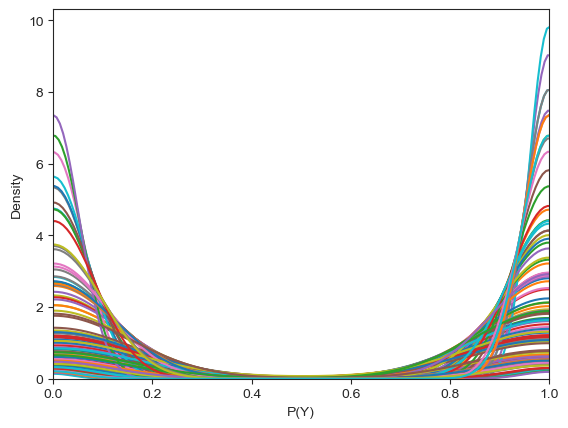

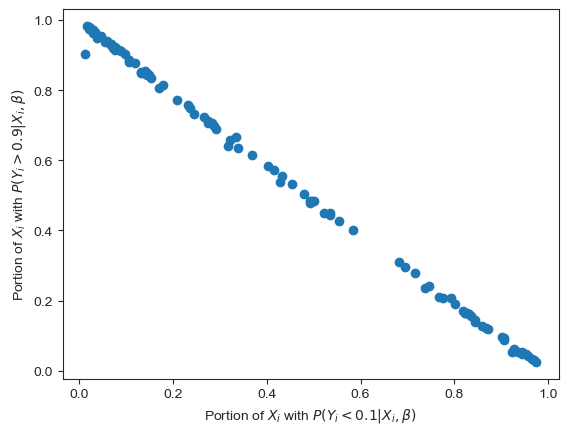

In [220]:
zero_counts = []
one_counts = []
lap = sp.stats.laplace(loc=0, scale=1)
for i in range(100):
    double_exponential_rvs = lap.rvs(size=len(raw_df))
    Y_vals = []
    for x in data_rand['X']:
        z = sum(np.array(x) * double_exponential_rvs)
        Y_vals.append(np.exp(z) / (1 + np.exp(z)))
    Y_vals = np.array(Y_vals)
    zero_counts.append(len(Y_vals[Y_vals<0.1]))
    one_counts.append(len(Y_vals[Y_vals>0.9]))
    sns.kdeplot(Y_vals)
plt.xlim([0, 1])
plt.xlabel('P(Y)')
plt.savefig('./plots/laplace_prior_density.png')
plt.show()

zero_counts = np.array(zero_counts) / len(data_rand['X'])
one_counts = np.array(one_counts) / len(data_rand['X'])
plt.scatter(zero_counts, one_counts)
plt.xlabel(r'Portion of $X_i$ with $P(Y_i<0.1|X_i,\beta)$')
plt.ylabel(r'Portion of $X_i$ with $P(Y_i>0.9|X_i,\beta)$')

plt.savefig('./plots/laplace_prior_zeros.png')
plt.show()

#### 2. Horseshoe

/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/2223119223.py:14: RuntimeWarning: overflow encountered in exp
  Y_vals.append(np.exp(z) / (1 + np.exp(z)))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/2223119223.py:14: RuntimeWarning: invalid value encountered in scalar divide
  Y_vals.append(np.exp(z) / (1 + np.exp(z)))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/2223119223.py:14: RuntimeWarning: overflow encountered in exp
  Y_vals.append(np.exp(z) / (1 + np.exp(z)))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/2223119223.py:14: RuntimeWarning: invalid value encountered in scalar divide
  Y_vals.append(np.exp(z) / (1 + np.exp(z)))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/2223119223.py:14: RuntimeWarning: overflow encountered in exp
  Y_vals.append(np.exp(z) / (1 + np.exp(z)))
/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_85316/2223119223.py:14: RuntimeWarning: invalid val

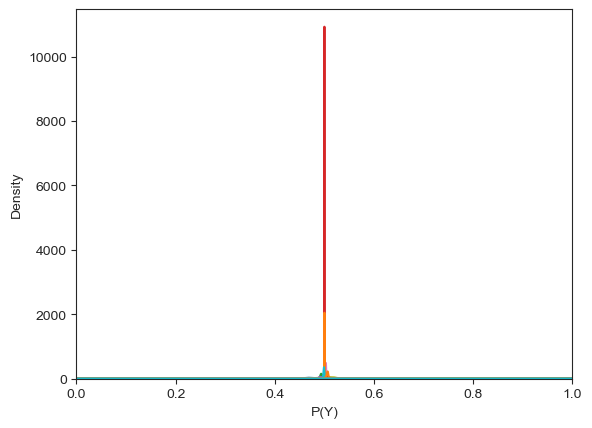

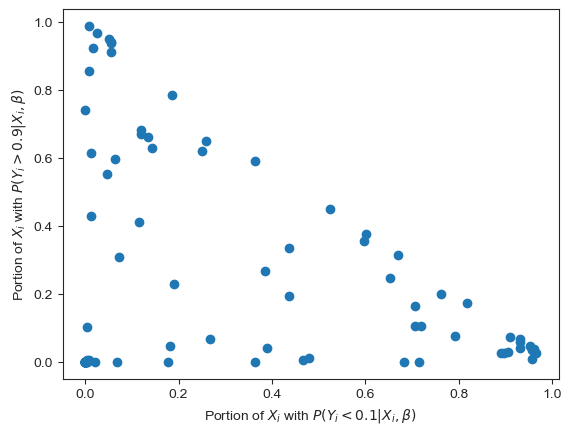

In [221]:
zero_counts = []
one_counts = []
n = 100
lam = sp.stats.cauchy(loc=0, scale=0.5)
tau = sp.stats.cauchy.rvs(loc=0, scale=0.5, size=n)
for i in range(100):
    lam_rvs = lam.rvs(size=len(raw_df))
    tau_2 = tau[i]*tau[i]
    for l in lam_rvs:
        norm_rvs = sp.stats.norm.rvs(loc=0, scale=l*l*tau_2, size=len(raw_df))
    Y_vals = []
    for x in data_rand['X']:
        z = sum(np.array(x) * norm_rvs)
        Y_vals.append(np.exp(z) / (1 + np.exp(z)))
    Y_vals = np.array(Y_vals)
    zero_counts.append(len(Y_vals[Y_vals<0.1]))
    one_counts.append(len(Y_vals[Y_vals>0.9]))
    sns.kdeplot(Y_vals)
plt.xlim([0, 1])
plt.xlabel('P(Y)')
plt.savefig('./plots/horseshoe_prior_density.png')
plt.show()

zero_counts = np.array(zero_counts) / len(data_rand['X'])
one_counts = np.array(one_counts) / len(data_rand['X'])
plt.scatter(zero_counts, one_counts)
plt.xlabel(r'Portion of $X_i$ with $P(Y_i<0.1|X_i,\beta)$')
plt.ylabel(r'Portion of $X_i$ with $P(Y_i>0.9|X_i,\beta)$')

plt.savefig('./plots/horseshoe_prior_zeros.png')
plt.show()

We develop a multinomial model where the health status (Normal or Diseased) associated with a sample $m$ is the dependent variable $Y_m\in\{0,1\}$ and the independent variable $X^m$ is the gene expression of the sample. We will model a score $Z=\beta\cdot X$, which can be converted into a probability of $Y_m$ given $(X^m,\beta)$. In our initial implementation, we model the $\beta$ values as being drawn from a normal distribution. Our model is therefore:
$$Y\in\{0, 1\}$$
$$Y^i\sim\text{Bernoulli}\left(\rho_i\right)$$
$$Z_i=\sum_j x_j^i\beta_j$$
$$\rho_i=\text{logit}\left(Z_i\right)$$
$$\beta_j\sim Normal\left(0,\sigma\right)$$
$$\sigma=1$$

In [ ]:
base_stan_path = "/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan"

In [ ]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_code = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ normal(0, 1);
    beta ~ normal(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [ ]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_laplace = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ double_exponential(0, 1);
    beta ~ double_exponential(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [ ]:
model_horseshoe = """data {
  int N;         // number of samples
  int q;         // number of predictors
  real X[N, q];  // predictors
  int<lower=0,upper=1> Y[N];     // response
}
parameters {
  vector<lower=0>[q] lambda;
  real<lower=0> tau;
  vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = 0;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
  lambda ~ cauchy(0, 0.5);
  tau ~ cauchy(0, 0.5);
  for (i in 1:q) {
    beta[i] ~ normal(0, lambda[i] * tau);
  }
  for (i in 1:N) {
    Y[i] ~ bernoulli_logit(z[i]);
  }
}
"""
with open(base_stan_path + '/genes/model_norm/model_horseshoe.stan', 'w') as f:
    f.write(model_horseshoe)

In [ ]:
model_laplace_mix = """data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha_beta;
    real alpha_gamma;
    vector[q] beta;
    vector[q] gamma;
    real<lower=0,upper=1> pi;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = pi * alpha_beta + (1-pi) * alpha_gamma;
        for (j in 1:q)
        {
            z[i] += pi * beta[j] * X[i, j] + (1-pi) * gamma[j] * X[i, j];
        }
    }
}
model {
    alpha_beta ~ double_exponential(0, 1);
    alpha_gamma
    pi ~ beta(1, 1);
    beta ~ double_exponential(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [ ]:
# https://mc-stan.org/docs/stan-users-guide/multivariate-hierarchical-priors.html
model_laplace_region = """data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int p;        // number of regions
    int region[N]; // region of each sample
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    vector[p] alpha;             // intercept for group
    array[p] vector[q] beta;     // indiv coeffs by group
    vector<lower=0>[p] sigma;    // scale for group coefficients
    vector<lower=0>[p] mu;    // location for group coefficients
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha[region[i]];
        for (j in 1:q)
        {
            z[i] += beta[region[i], j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    to_vector(sigma) ~ exponential(1);
    to_vector(mu) ~ normal(0, 1);
    for (j in 1:p){
        alpha[j] ~ double_exponential(mu[j], sigma[j]);
        for (i in 1:q) {
            beta[j, i] ~ double_exponential(mu[j], sigma[j]);
        }
    }
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""
with open(base_stan_path + '/genes/model_norm/model_laplace_region.stan', 'w') as f:
    f.write(model_laplace_region)

In [ ]:
model = stan.build(model_laplace_region, data=data_indv)

In [ ]:
fit = model.sample(num_chains=4, num_samples=1000)

From https://www.cs.bham.ac.uk/~axk/laplace.pdf,
$$_t=\frac{\sum_n(y_n-\sum_{t'\neq t}w_{t'}x_{t'n})x_{tn}}{\sum_n x^2_{tn}}$$


### Evaluating the Laplace mixture model

In [ ]:
t_out = pd.read_csv("/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output.csv",
                    comment='#')
print(t_out.head())
t_alpha_beta = t_out['alpha_beta'][0]
t_alpha_gamma = t_out['alpha_gamma'][0]
pi = t_out['pi'][0]
print(pi)
t_betas = [t_out[col][0] for col in t_out.columns if 'beta.' in col]
t_gammas = [t_out[col][0] for col in t_out.columns if 'gamma.' in col]
print(sum(t_betas))
print(sum(t_gammas))
abs_betas = np.abs(t_betas)
np_betas = np.array(t_betas)
# genes_to_use = df[abs_betas > 0.01]['gene']
# t_betas_to_use = np_betas[abs_betas > 0.01]

In [ ]:
### Laplace Mix Model - training data

scaled = [pi * np.array(t_betas) * x[:] + (1-pi) * np.array(t_gammas) * x[:] for x in X]
z = [t_out['alpha_beta'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

plt.show()

In [ ]:
scaled = [pi * np.array(t_betas) * x[:] + (1-pi) * np.array(t_gammas) * x[:] for x in test_X]
z = [t_out['alpha_beta'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

print(Y)
print(Y_tilde)
plt.show()

sns.scatterplot(x=[i for i in range(len(t_betas))], y=t_betas, c='b', s=2, label='beta')
sns.scatterplot(x=[i for i in range(len(t_gammas))], y=t_gammas, c='r', s=2, label='gamma')
plt.show()

accuracy = []
for i in range(len(Y_tilde)):
    if Y_tilde[i] > 0.5:
        accuracy.append(1 if test_Y[i] == 1 else 0)
    else:
        accuracy.append(1 if test_Y[i] == 0 else 0)
summary_table = pd.DataFrame({'ROI': test_column_list, 'Y': test_Y, 'P(Y)': Y_tilde, 'accuracy': accuracy, 'samples': 1})
print(summary_table)
s_g = summary_table.groupby('Y').sum()
print(s_g)